In [40]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
plt.style.use('dark_background')
from data_load_preprocess import data

import torch
from torch.autograd import Variable
SAVFIG = False
from viz import viz


# load results from a directory

In [3]:
out_dir_main = '/scratch/users/vision/chandan/dl_theory/'
print(os.listdir(out_dir_main))
folder = 'sweep_init_d=1_concentrated'

['sweep_init_large', 'sweep_init_small', 'resweep_seed_and_hidden1', 'sweep_init_d=10_concentrated', 'sweep_init_d=1_concentrated', 'sweep_init_d=6_centered_long', 'sweep_seed_and_hidden1', 'test', 'sweep_init_small_centered']


In [4]:
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
results.describe()

,N,batch_size,d_in,d_out,gamma_optimizer,hidden1,lr,max_acc,min_loss,num_iters,num_layers,seed,step_size_optimizer,t_min_loss_plus_10_perc,t_min_loss_plus_20_perc,t_min_loss_plus_5_perc
count,960.0,960.0,960.0,960.0,9.600000e+02,960.000000,9.600000e+02,960.000000,960.000000,960.0,960.0,960.000000,960.0,960.000000,960.000000,960.000000
mean,1000.0,1000.0,1.0,2.0,9.000000e-01,25.125000,1.000000e-03,74.235521,394.221544,10000.0,2.0,29.500000,1000.0,766.721875,623.452083,1120.528125
std,0.0,0.0,0.0,0.0,1.488474e-14,32.591653,6.508604e-19,9.860401,80.462610,0.0,0.0,17.327129,0.0,1728.943873,1549.374785,1991.201899
min,1000.0,1000.0,1.0,2.0,9.000000e-01,1.000000,1.000000e-03,63.400000,2.475341,10000.0,2.0,0.000000,1000.0,0.000000,0.000000,0.000000
25%,1000.0,1000.0,1.0,2.0,9.000000e-01,2.750000,1.000000e-03,66.600000,391.276711,10000.0,2.0,14.750000,1000.0,1.000000,0.000000,2.000000
50%,1000.0,1000.0,1.0,2.0,9.000000e-01,7.500000,1.000000e-03,68.400000,422.057404,10000.0,2.0,29.500000,1000.0,2.000000,1.000000,98.000000
75%,1000.0,1000.0,1.0,2.0,9.000000e-01,35.000000,1.000000e-03,83.300000,438.091270,10000.0,2.0,44.250000,1000.0,307.000000,5.000000,1339.750000
max,1000.0,1000.0,1.0,2.0,9.000000e-01,100.000000,1.000000e-03,100.000000,653.993164,10000.0,2.0,59.000000,1000.0,9777.000000,9592.000000,9883.000000


# compare losses by hidden layer dim

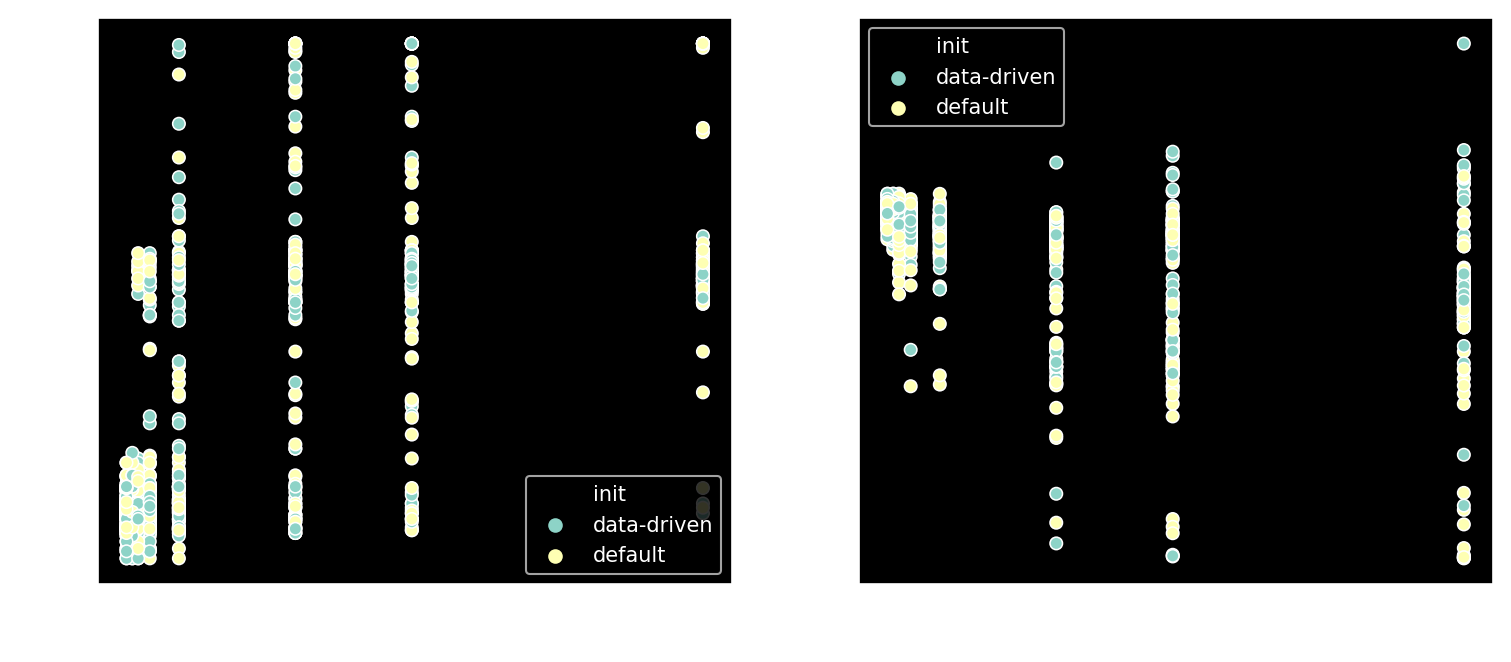

In [8]:
def lmplot(colx, coly, data=results, style='.', alpha=1., label='', bar=False):    
    plt.plot(data[colx], data[coly], style, alpha=alpha, label=label) 
#     plt.bar(data[colx], data[coly], label=label) #, style, alpha=alpha, label=label)
    plt.xlabel(colx)
    plt.ylabel(coly)
    if label!='':
        plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(12, 5), dpi=150, ncols=2, nrows=1)
sns.scatterplot(x='hidden1', y='max_acc', data=results, ax=ax[0], hue="init")

sns.scatterplot(x='hidden1', y='min_loss', data=results, ax=ax[1], hue="init")
plt.show()

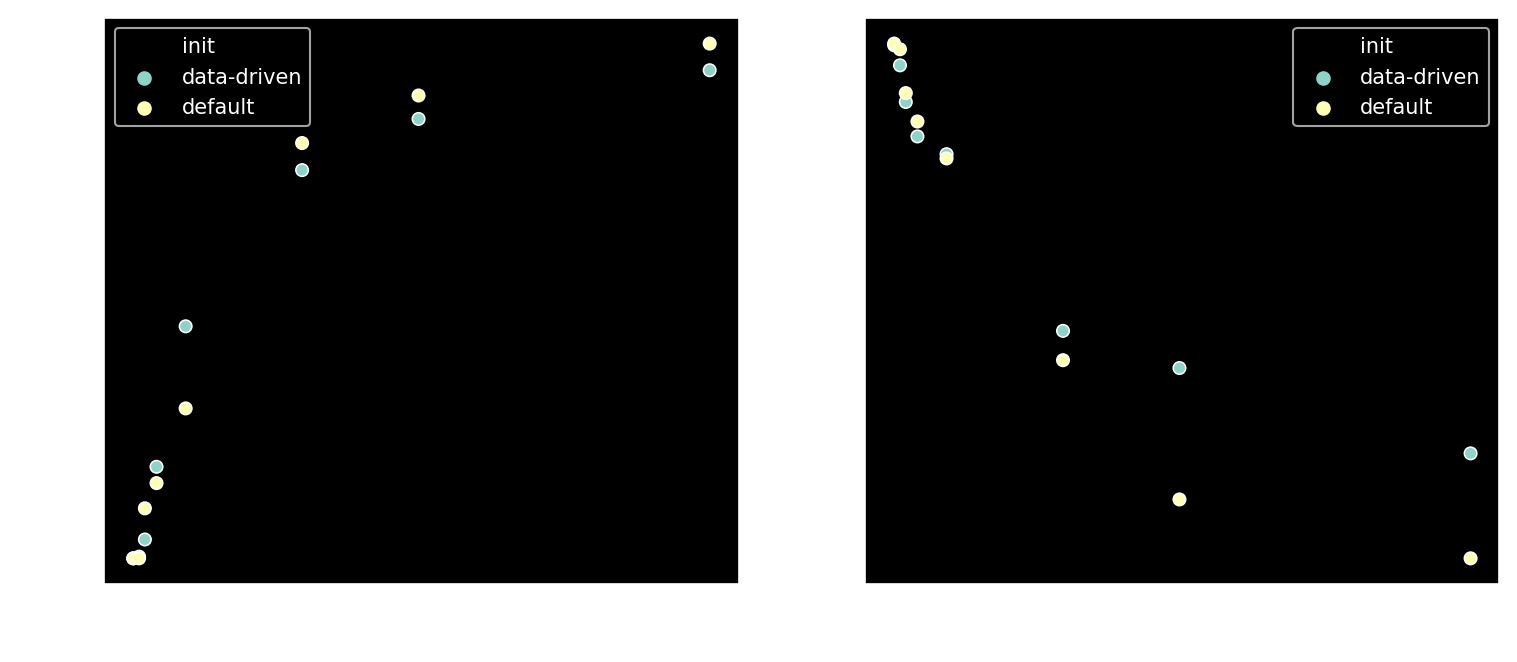

In [35]:
max_accs_default = results[results['init']=='default'].groupby(['hidden1']).mean().reset_index()
max_accs_data = results[results['init']=='data-driven'].groupby(['hidden1']).mean().reset_index()
max_accs_data['init'] = 'data-driven'
max_accs_default['init'] = 'default'
max_accs = pd.concat([max_accs_data, max_accs_default]) # todo: there's probably a nicer way to do this in pd


fig, ax = plt.subplots(figsize=(12, 5), dpi=150, ncols=2, nrows=1)
sns.scatterplot(x='hidden1', y='max_acc', data=max_accs, ax=ax[0], hue="init")

sns.scatterplot(x='hidden1', y='min_loss', data=max_accs, ax=ax[1], hue="init")
plt.show()

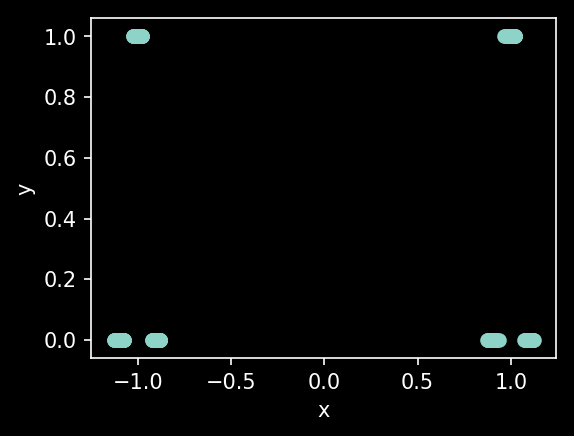

In [48]:
# plot data (only 1d)
X, y_onehot, y_scalar = data.generate_gaussian_data(results.N[0], means=results.means[0], sds=results.sds[0], labs=results.labs[0])
plt.figure(figsize=(4, 3), dpi=150)
viz.plot_data(X, y_scalar)

/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/accounts/projects/vision/.local/lib/p

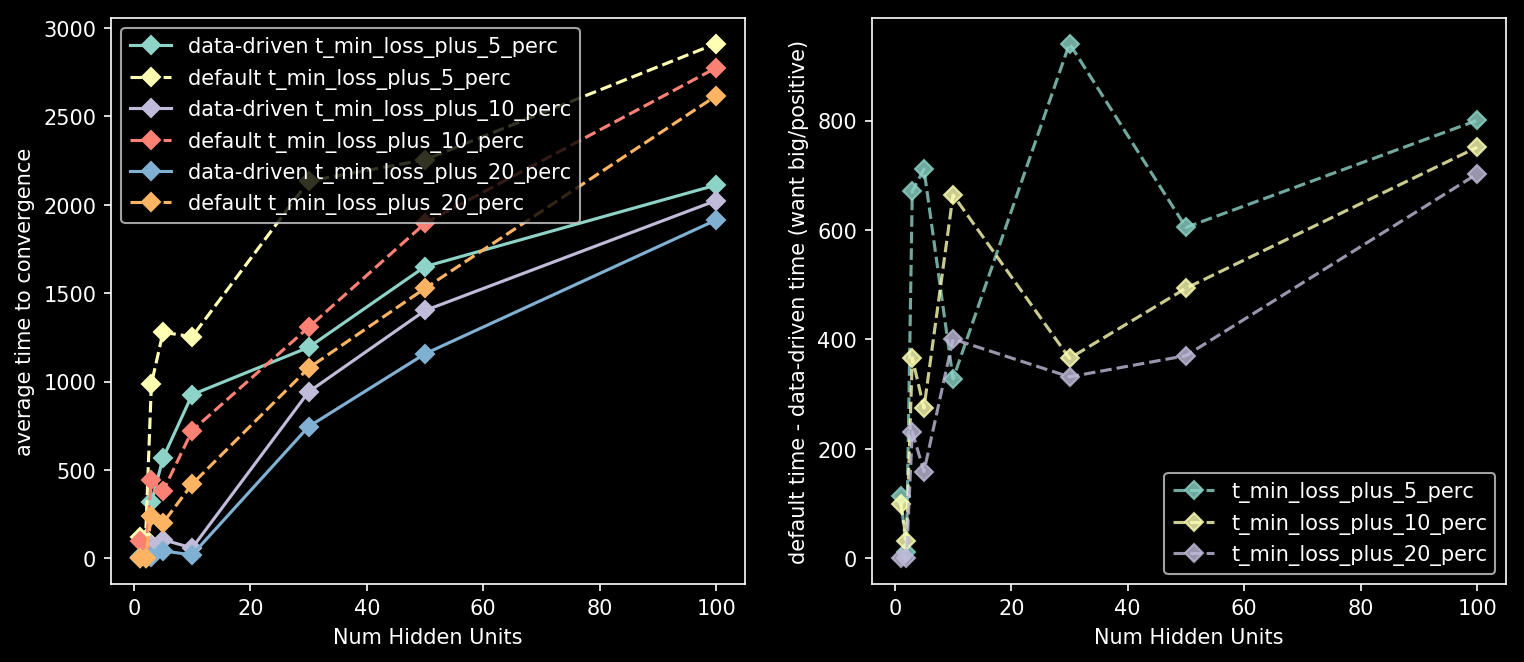

In [49]:
# plot mean time to convergence
plt.figure(figsize=(12, 5), dpi=150)
for converge_def in ['t_min_loss_plus_5_perc', 't_min_loss_plus_10_perc', 't_min_loss_plus_20_perc']:
    t_converge_default = results[results['init']=='default'][[converge_def, 'hidden1']].groupby(['hidden1']).mean().reset_index()
    t_converge_data = results[results['init']=='data-driven'][[converge_def, 'min_loss', 'hidden1']].groupby(['hidden1']).mean().reset_index()
    plt.subplot(121)
    lmplot('hidden1', converge_def, t_converge_data, style='-D', label='data-driven ' + converge_def)
    lmplot('hidden1', converge_def, t_converge_default, style='--D', label='default ' + converge_def)
    plt.ylabel('average time to convergence')
    plt.xlabel('Num Hidden Units')
    
    
    plt.subplot(122)
    plt.plot(t_converge_default['hidden1'], 
             t_converge_default[converge_def] - t_converge_data[converge_def],
            '--D', label=converge_def, alpha=0.8) #, style, alpha=alpha, label=label) 
    plt.xlabel('Num Hidden Units')
    plt.ylabel('default time - data-driven time (want big/positive)')

    plt.legend(loc='best')
    
plt.show()

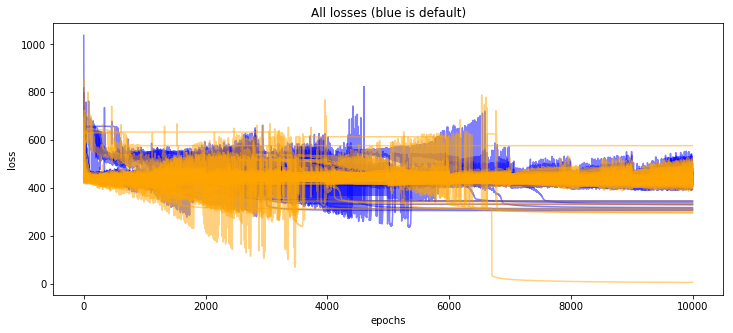

In [11]:
# plot all losses
plt.figure(figsize=(12, 5))
r_df = results[results.init == 'default']['losses']
r_data = results[results.init == 'data-driven']['losses']
subsample = 0.1
loss_curves_default = np.array([np.array(x) for x in r_df.values if np.random.rand() < subsample])
loss_curves_data = np.array([np.array(x) for x in r_data.values if np.random.rand() < subsample])

plt.plot(loss_curves_default.T, alpha=0.5, color='blue', label='default')
plt.plot(loss_curves_data.T, alpha=0.5, color='orange', label='data_driven')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('All losses (blue is default)')
# plt.legend()

plt.show()